# The Tampa Bay Times and school performance

**Story:** [The story](http://www.tampabay.com/projects/2015/investigations/pinellas-failure-factories/), and [a critique](https://rogueedu.blogspot.com/2015/08/fcat-reading-scores-only-two-of-five.html)

**Author:** A million people, but I believe Nathaniel Lash did the data analysis

**Topics:** Linear Regression, Residuals

**Datasets**

* **0066897-gr04_rsch_2014.xls:** 4th grader pass rates for standardized tests, from Florida Dept of Education
* **FRL-1314-School-Web-Survey-3-Final.xls:** Free and reduced price lunch data, from Florida Dept of Education
* **MembershipSchoolRaceGender1415.xls:** School population by gender, from Florida Dept of Education

# What's the story?

We're trying to see what kind of effect race and poverty have on school test score data. Their actual story doesn't include a regression, but they used one behind the scenes for research.

<p class="reading-options">
  <a class="btn" href="/tampa-bay-times-schools/linear-regression-on-florida-schools">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/tampa-bay-times-schools/notebooks/Linear regression on Florida schools.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/tampa-bay-times-schools/notebooks/Linear regression on Florida schools.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **0066897-gr04_rsch_2014.xls:** test scores - fourth grade test scores as of 2014
* **FRL-1314-School-Web-Survey-3-Final.xls:** free and reduced lunch status - for the 2014 school year
* **MembershipSchoolRaceGender1415.xls:** race and gender by school - for the 2014-2015 school year


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/tampa-bay-times-schools/data/0066897-gr04_rsch_2014.xls -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/tampa-bay-times-schools/data/FRL-1314-School-Web-Survey-3-Final.xls -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/tampa-bay-times-schools/data/MembershipSchoolRaceGender1415.xls -P data

## Imports

You'll want pandas and seaborn. You'll want want to set pandas to display a lot of columns and rows at a time.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

# Reading in our test scores data

While we have a lot of options for what tests we can use, let's stick with reading scores.

* **Tip:** There's a lot of junk up at the file, so you'll want to skip a few of those rows.
* **Tip:** Ouch, even if we skip rows there are still a couple bad ones - the "Number of possible points" and "STATE TOTALS" rows. Get rid of them, too. You can drop them after you've read the data in, if you'd like.
* **Tip:** Sometimes the school number starts with `0`, but pandas will drop it if it thinks the column is an integer. Tell `.read_csv` to read the column in as a string, instead.

In [2]:
reading_scores = pd.read_excel("data/0066897-gr04_rsch_2014.xls", skiprows=10, dtype={'School Number': 'str'}, na_values=['*'])
reading_scores.head(4)

,Grade,District Number,District Name,School Number,School Name,Number of Students,Mean Developmental Scale Score,1,2,3,4,5,Percentage Passing (Achievement Levels 3 and Above),Vocabulary,Reading Application,Literary Analysis: Fiction and Nonfiction,Informational Text and Research Process
0,4,Number of Points Possible,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,14.0,11.0,11.0
1,4,00,STATE TOTALS,0000,GRADE 04,"196,786",213.0,14.0,25.0,26.0,24.0,11.0,61.0,6.0,10.0,8.0,8.0
2,4,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,45,203.0,24.0,40.0,24.0,9.0,2.0,36.0,5.0,8.0,7.0,7.0
3,4,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,84,219.0,6.0,20.0,32.0,26.0,15.0,74.0,6.0,11.0,8.0,8.0


In [3]:
reading_scores = reading_scores.loc[2:]
reading_scores.head(4)

,Grade,District Number,District Name,School Number,School Name,Number of Students,Mean Developmental Scale Score,1,2,3,4,5,Percentage Passing (Achievement Levels 3 and Above),Vocabulary,Reading Application,Literary Analysis: Fiction and Nonfiction,Informational Text and Research Process
2,4,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,45,203.0,24.0,40.0,24.0,9.0,2.0,36.0,5.0,8.0,7.0,7.0
3,4,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,84,219.0,6.0,20.0,32.0,26.0,15.0,74.0,6.0,11.0,8.0,8.0
4,4,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHOOL,85,223.0,6.0,24.0,18.0,25.0,28.0,71.0,7.0,11.0,8.0,8.0
5,4,01,ALACHUA,0052,A.QUINN JONES/EXCEP.STUDENT CENTER,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Getting an average

Try to get the median of the `Percentage Passing (Achievement Levels 3 and Above)` column. Oof, it doesn't work! Take a look at your data and see if there's something that needs to be done with `na_values`.

In [4]:
reading_scores['Percentage Passing (Achievement Levels 3 and Above)'].median()

58.0

### Confirm that you have 2207 rows and 17 columns, and that the first school is CHARLES W. DUVAL ELEM SCHOOL

In [5]:
reading_scores.shape

(2207, 17)

# Read in lunch data

We'll be using free lunch as a proxy for poverty.

* **Tip:** You'll need to specify the sheet you're interested in
* **Tip:** Again, the top of the file is kind of messy
* **Tip:** It might be easiest to just specify the names for the columns yourself

In [6]:
colnames = ['district_no', 'district_name', 'school_no', 
            'school_name', 'total_members', 'num_free', 
            'num_reduced', 'provision_2', 'direct_cert']

lunch = pd.read_excel("data/FRL-1314-School-Web-Survey-3-Final.xls",
                      sheet_name='School',
                      skiprows=5,
                      dtype={'school_no': 'str', 'district_no': 'str'},
                      names=colnames,
                      na_values=['*'])
lunch.head()

,district_no,district_name,school_no,school_name,total_members,num_free,num_reduced,provision_2,direct_cert
0,1,ALACHUA,21,CHARLES W. DUVAL ELEM SCHOOL,318.0,290.0,15.0,0.0,0.0
1,1,ALACHUA,31,J. J. FINLEY ELEMENTARY SCHOOL,589.0,297.0,25.0,0.0,0.0
2,1,ALACHUA,41,STEPHEN FOSTER ELEMENTARY SCHL,458.0,257.0,21.0,0.0,0.0
3,1,ALACHUA,52,A.QUINN JONES/EXCEP.STUD.CTR.,71.0,55.0,2.0,0.0,0.0
4,1,ALACHUA,71,LAKE FOREST ELEMENTARY SCHOOL,307.0,286.0,8.0,0.0,0.0


## Calculating a column

Let's add in a new column that is the percent of students who are eligible for free or reduced-price lunch.

* Free, reduced price, provision 2, and CEP direct cert are all kinds of reduced lunch.
* Total members it the total number of students at the school.
* **Tip:** If you get an error, read your error message. Check the datatype of your columns, and take a look at your dataset. Maybe you need to add an `na_values` to your `read_excel` to deal with something in there?

In [7]:
lunch['pct_free_or_reduced'] = (lunch.num_free + lunch.num_reduced + lunch.provision_2 + lunch.direct_cert) / lunch.total_members
lunch.head()

,district_no,district_name,school_no,school_name,total_members,num_free,num_reduced,provision_2,direct_cert,pct_free_or_reduced
0,1,ALACHUA,21,CHARLES W. DUVAL ELEM SCHOOL,318.0,290.0,15.0,0.0,0.0,0.959119
1,1,ALACHUA,31,J. J. FINLEY ELEMENTARY SCHOOL,589.0,297.0,25.0,0.0,0.0,0.546689
2,1,ALACHUA,41,STEPHEN FOSTER ELEMENTARY SCHL,458.0,257.0,21.0,0.0,0.0,0.606987
3,1,ALACHUA,52,A.QUINN JONES/EXCEP.STUD.CTR.,71.0,55.0,2.0,0.0,0.0,0.802817
4,1,ALACHUA,71,LAKE FOREST ELEMENTARY SCHOOL,307.0,286.0,8.0,0.0,0.0,0.957655


## Fixing district and school numbers

Even if you specify `dtype` when you're reading in this data, it still drops the leading `0`s that you see in Excel for the district and school numbers. Use `.str.pad` to add them back in.

* **Tip:** School numbers should be 4 characters long, district number should be 2 characters.

In [8]:
lunch.school_no = lunch.school_no.str.pad(width=4, side='left', fillchar='0')
lunch.district_no = lunch.district_no.str.pad(width=2, side='left', fillchar='0')
lunch.head(3)

,district_no,district_name,school_no,school_name,total_members,num_free,num_reduced,provision_2,direct_cert,pct_free_or_reduced
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,318.0,290.0,15.0,0.0,0.0,0.959119
1,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,589.0,297.0,25.0,0.0,0.0,0.546689
2,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHL,458.0,257.0,21.0,0.0,0.0,0.606987


### Confirm you have 3987 rows and 10 columns

In [9]:
lunch.shape

(3987, 10)

# Read in race data

* **Tip:** Beware! The file uses a space `' '` instead of an empty string `''` when having missing data, so you might want to let `pd.read_excel` know about that special kind of missing data.

In [10]:
race = pd.read_excel("data/MembershipSchoolRaceGender1415.xls",
                     sheet_name='SCHOOL',
                     skiprows=4,
                     dtype={'School #': 'str', 'District #': 'str'},
                     na_values=[' ', '*'])
race.head(10)

,District #,District,School #,School,Grade,White,Black or African American,Hispanic/Latino,Asian,Native Hawaiian or Other Pacific Islander,American Indian or Alaska Native,Two or More Races,Female Total,Male Total,Total
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,PK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,KG,NaN,36.0,2.0,NaN,NaN,NaN,NaN,15.0,23.0,38.0
2,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,1,NaN,33.0,3.0,1.0,NaN,NaN,NaN,16.0,21.0,37.0
3,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,2,1.0,38.0,1.0,NaN,NaN,NaN,3.0,21.0,22.0,43.0
4,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,3,NaN,32.0,4.0,NaN,NaN,NaN,2.0,18.0,20.0,38.0
5,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,4,NaN,33.0,NaN,NaN,NaN,NaN,NaN,19.0,14.0,33.0
6,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,5,2.0,24.0,NaN,NaN,NaN,NaN,2.0,13.0,15.0,28.0
7,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## These columns are stupid

If you look at the column names with `df.columns`, you'll see the they have extra spacs after them. This is terrible! 

You can use something like `race.columns = race.columns.str.strip()` to fix that, then columns will behave properly.

In [11]:
race.columns = race.columns.str.strip()

## Cleaning up race counts

When a school has no students of a certain race, it just doesn't put anything in the column. This means a lot of `NaN` values that should be zeros! Fill in those `NaN` values with 0.

In [12]:
race = race.fillna(0)
race.head(15)

,District #,District,School #,School,Grade,White,Black or African American,Hispanic/Latino,Asian,Native Hawaiian or Other Pacific Islander,American Indian or Alaska Native,Two or More Races,Female Total,Male Total,Total
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,PK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,KG,0.0,36.0,2.0,0.0,0.0,0.0,0.0,15.0,23.0,38.0
2,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,1,0.0,33.0,3.0,1.0,0.0,0.0,0.0,16.0,21.0,37.0
3,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,2,1.0,38.0,1.0,0.0,0.0,0.0,3.0,21.0,22.0,43.0
4,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,3,0.0,32.0,4.0,0.0,0.0,0.0,2.0,18.0,20.0,38.0
5,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,4,0.0,33.0,0.0,0.0,0.0,0.0,0.0,19.0,14.0,33.0
6,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,5,2.0,24.0,0.0,0.0,0.0,0.0,2.0,13.0,15.0,28.0
7,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Finding the totals

One row for each school is the `TOTAL` row, that adds up all the other rows and provides an aggregate. Instead of adding ourselves, let's try to use this row.

First, try to filter to only look at the total row for each school.

In [13]:
race[race.Grade == 'TOTAL'].head()

,District #,District,School #,School,Grade,White,Black or African American,Hispanic/Latino,Asian,Native Hawaiian or Other Pacific Islander,American Indian or Alaska Native,Two or More Races,Female Total,Male Total,Total
14,01,ALACHUA,0021,SCHOOL TOTALS,TOTAL,3.0,196.0,10.0,1.0,0.0,0.0,7.0,102.0,115.0,217.0
29,01,ALACHUA,0031,SCHOOL TOTALS,TOTAL,214.0,173.0,108.0,76.0,1.0,0.0,30.0,297.0,305.0,602.0
44,01,ALACHUA,0041,SCHOOL TOTALS,TOTAL,161.0,182.0,44.0,37.0,2.0,0.0,49.0,247.0,228.0,475.0
59,01,ALACHUA,0052,SCHOOL TOTALS,TOTAL,22.0,64.0,2.0,0.0,0.0,0.0,8.0,20.0,76.0,96.0
74,01,ALACHUA,0071,SCHOOL TOTALS,TOTAL,28.0,276.0,3.0,1.0,0.0,1.0,16.0,152.0,173.0,325.0


It doesn't list the school's name!

There are a lot of ways to fix this, but my favorite is to replace all of the instances of `"SCHOOL TOTAL"` with `NaN`, then have pandas copy down the value from above it. You can use this code:

```python
race.School = race.School.replace("SCHOOL TOTALS", np.nan).fillna(method='ffill')
```

In [14]:
race.School = race.School.replace("SCHOOL TOTALS", np.nan).fillna(method='ffill')

Now let's try again to see the school totals.

In [15]:
race[race.Grade == 'TOTAL'].head()

,District #,District,School #,School,Grade,White,Black or African American,Hispanic/Latino,Asian,Native Hawaiian or Other Pacific Islander,American Indian or Alaska Native,Two or More Races,Female Total,Male Total,Total
14,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,TOTAL,3.0,196.0,10.0,1.0,0.0,0.0,7.0,102.0,115.0,217.0
29,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,TOTAL,214.0,173.0,108.0,76.0,1.0,0.0,30.0,297.0,305.0,602.0
44,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHL,TOTAL,161.0,182.0,44.0,37.0,2.0,0.0,49.0,247.0,228.0,475.0
59,01,ALACHUA,0052,A.QUINN JONES/EXCEP.STUD.CTR.,TOTAL,22.0,64.0,2.0,0.0,0.0,0.0,8.0,20.0,76.0,96.0
74,01,ALACHUA,0071,LAKE FOREST ELEMENTARY SCHOOL,TOTAL,28.0,276.0,3.0,1.0,0.0,1.0,16.0,152.0,173.0,325.0


### Create a new dataframe that is only the 'TOTAL' rows, and confirm it is 3992 rows and 15 columns

In [16]:
race_total = race[race.Grade == 'TOTAL']

In [17]:
race_total.shape

(3992, 15)

### Adding in percentages

Create a new column called `pct_black` that is the percentage of black students.

* **Tip:** If this isn't working, think about how you fixed a similar problem with lunch data up above

Typically you'd take a larger view of race issues, but in this case we're just trying to reproduce what was done by others.

In [18]:
race_total['pct_black'] = race_total['Black or African American'] / race_total['Total']
race_total.head()

,District #,District,School #,School,Grade,White,Black or African American,Hispanic/Latino,Asian,Native Hawaiian or Other Pacific Islander,American Indian or Alaska Native,Two or More Races,Female Total,Male Total,Total,pct_black
14,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,TOTAL,3.0,196.0,10.0,1.0,0.0,0.0,7.0,102.0,115.0,217.0,0.903226
29,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,TOTAL,214.0,173.0,108.0,76.0,1.0,0.0,30.0,297.0,305.0,602.0,0.287375
44,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHL,TOTAL,161.0,182.0,44.0,37.0,2.0,0.0,49.0,247.0,228.0,475.0,0.383158
59,01,ALACHUA,0052,A.QUINN JONES/EXCEP.STUD.CTR.,TOTAL,22.0,64.0,2.0,0.0,0.0,0.0,8.0,20.0,76.0,96.0,0.666667
74,01,ALACHUA,0071,LAKE FOREST ELEMENTARY SCHOOL,TOTAL,28.0,276.0,3.0,1.0,0.0,1.0,16.0,152.0,173.0,325.0,0.849231


### Confirm that your dataframe has 3992 rows and 16 columns

In [19]:
race_total.shape

(3992, 16)

# Merging our datasets

Let's take a look at the first couple rows of our three datasets:

* Our reading score data
* Our free lunch data
* Our race data

In [20]:
reading_scores.head(2)

,Grade,District Number,District Name,School Number,School Name,Number of Students,Mean Developmental Scale Score,1,2,3,4,5,Percentage Passing (Achievement Levels 3 and Above),Vocabulary,Reading Application,Literary Analysis: Fiction and Nonfiction,Informational Text and Research Process
2,4,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,45,203.0,24.0,40.0,24.0,9.0,2.0,36.0,5.0,8.0,7.0,7.0
3,4,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,84,219.0,6.0,20.0,32.0,26.0,15.0,74.0,6.0,11.0,8.0,8.0


In [21]:
lunch.head(2)

,district_no,district_name,school_no,school_name,total_members,num_free,num_reduced,provision_2,direct_cert,pct_free_or_reduced
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,318.0,290.0,15.0,0.0,0.0,0.959119
1,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,589.0,297.0,25.0,0.0,0.0,0.546689


In [22]:
race.head(2)

,District #,District,School #,School,Grade,White,Black or African American,Hispanic/Latino,Asian,Native Hawaiian or Other Pacific Islander,American Indian or Alaska Native,Two or More Races,Female Total,Male Total,Total
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,PK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,KG,0.0,36.0,2.0,0.0,0.0,0.0,0.0,15.0,23.0,38.0


## Doing our merging

We need to merge them, but **school numbers repeat in difference districts.** You'll need to join on district AND school number to successfully perform each merge.

In [23]:
merged = reading_scores.merge(lunch,
                             left_on=['District Number', 'School Number'],
                             right_on=['district_no', 'school_no'])
merged.shape

(2205, 27)

In [24]:
merged = merged.merge(race_total,
                     left_on=['district_no', 'school_no'],
                     right_on=['District #', 'School #'])
merged.shape

(2189, 43)

 ### Confirm that you have around 2189 schools and 43 columns

If you have a lot more, it's probably because you merged on your original race dataframe instead of just the totals.

In [25]:
merged.shape

(2189, 43)

# Cleaning up our columns

We're interested in:

* District number
* School number
* Percent passing
* Percent free or reduced lunch
* Percent Black

Let's just select only those columns.

In [26]:
cols = [
    'District Number',
    'District Name',
    'School Number',
    'School Name',
    'Percentage Passing (Achievement Levels 3 and Above)',
    'pct_free_or_reduced',
    'pct_black'
    
]
merged = merged[cols]
merged.head()

,District Number,District Name,School Number,School Name,Percentage Passing (Achievement Levels 3 and Above),pct_free_or_reduced,pct_black
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,36.0,0.959119,0.903226
1,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,74.0,0.546689,0.287375
2,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHOOL,71.0,0.606987,0.383158
3,01,ALACHUA,0052,A.QUINN JONES/EXCEP.STUDENT CENTER,NaN,0.802817,0.666667
4,01,ALACHUA,0071,LAKE FOREST ELEMENTARY SCHOOL,19.0,0.957655,0.849231


While you're at it, you should probably rename `Percentage Passing (Achievement Levels 3 and Above)` to `pct_passing` because it's so so long.

In [27]:
merged = merged.rename(columns={'Percentage Passing (Achievement Levels 3 and Above)': 'pct_passing'})
merged.head()

,District Number,District Name,School Number,School Name,pct_passing,pct_free_or_reduced,pct_black
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,36.0,0.959119,0.903226
1,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,74.0,0.546689,0.287375
2,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHOOL,71.0,0.606987,0.383158
3,01,ALACHUA,0052,A.QUINN JONES/EXCEP.STUDENT CENTER,NaN,0.802817,0.666667
4,01,ALACHUA,0071,LAKE FOREST ELEMENTARY SCHOOL,19.0,0.957655,0.849231


### Converting to percentages

It's really easy to get mixed up later if we don't have our percentage columns as actual percents. Multiply any percentages that go 0-1 by 100 to turn them into 0-100 instead.

* **Tip:** Make sure your numbers are 1-100 after you multiply!

In [28]:
merged['pct_free_or_reduced'] = merged.pct_free_or_reduced * 100
merged['pct_black'] = merged.pct_black * 100
merged.head()

,District Number,District Name,School Number,School Name,pct_passing,pct_free_or_reduced,pct_black
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,36.0,95.911950,90.322581
1,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,74.0,54.668930,28.737542
2,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHOOL,71.0,60.698690,38.315789
3,01,ALACHUA,0052,A.QUINN JONES/EXCEP.STUDENT CENTER,NaN,80.281690,66.666667
4,01,ALACHUA,0071,LAKE FOREST ELEMENTARY SCHOOL,19.0,95.765472,84.923077


# Graphing our data

Use seaborn's `regplot` to plot the relationship between free/reduced lunch and percent passing, and the same with percent black.

* **Tip:** You can use `scatter_kws={'alpha':0.3}` to see things a bit more nicely

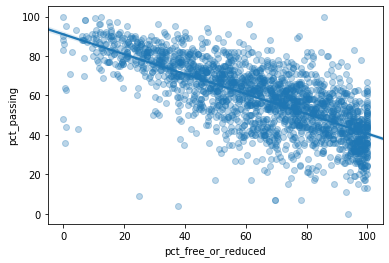

In [30]:
sns.regplot(data=merged, x='pct_free_or_reduced', y='pct_passing', scatter_kws={'alpha':0.3})

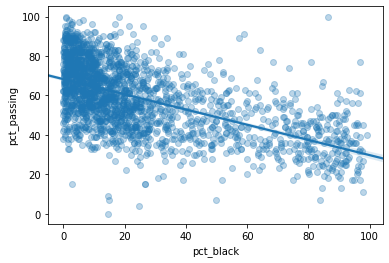

In [31]:
sns.regplot(data=merged, x='pct_black', y='pct_passing', scatter_kws={'alpha':0.3})

# Linear regression

Now let's be a little more exact: run a linear regression that takes into account both percent black and percent free or reduced.

* **Tip:** Use `.dropna()` to remove missing data
* **Tip:** Remember to use `sm.add_constant`!

In [32]:
merged = merged.dropna()

In [33]:
import statsmodels.api as sm

X = merged[['pct_black', 'pct_free_or_reduced']]
X = sm.add_constant(X)

y = merged['pct_passing']

model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            pct_passing   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     1398.
Date:                Tue, 16 Jul 2019   Prob (F-statistic):               0.00
Time:                        13:49:51   Log-Likelihood:                -7963.4
No. Observations:                2070   AIC:                         1.593e+04
Df Residuals:                    2067   BIC:                         1.595e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  89.3659      0.707    126.460      0.000      87.980      90.752
pct_black              -0.2041      0.011    -18.669      0.000      -0.226      -0.183
pct_free_or_reduced    -0.3984      0.012    -34.271      0.000      -0.421      -0.376
==============================================================================
Omnibus:                      178.385   Durbin-Watson:                   1.569
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              560.988
Skew:                          -0.423   Prob(JB):                    1.52e-122
Kurtosis:                       5.406   Cond. No.                         213.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Describe the relationship coefficient using "real" words

For example, "For every X change, we get Y change"

# Overperformers and underperformers

The point of the regression is to predict the percent passing, right? We can use `result.predict()` to get the predicted passing rate for each school. Try to run it below: 

In [34]:
result.predict()

array([32.72266299, 61.72216826, 57.36516932, ..., 77.7076644 ,
       42.22023935, 75.18874729])

Now, let's **save that value into a new column**, we can call it `predicted_passing`.

In [35]:
merged['predicted_passing'] = result.predict()
merged.head()

,District Number,District Name,School Number,School Name,pct_passing,pct_free_or_reduced,pct_black,predicted_passing
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,36.0,95.911950,90.322581,32.722663
1,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,74.0,54.668930,28.737542,61.722168
2,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHOOL,71.0,60.698690,38.315789,57.365169
4,01,ALACHUA,0071,LAKE FOREST ELEMENTARY SCHOOL,19.0,95.765472,84.923077,33.883060
6,01,ALACHUA,0091,LITTLEWOOD ELEMENTARY SCHOOL,56.0,59.394904,30.733229,59.432166


### Confirm that Charles W. Duval had a predicted passing rate of 32.

## Now let's find the difference between the predicted passing rate and the actual passing rate

If we're being stats-y, this is called **the residual**. Save it into a new column called.... `residual`.

* **Tip:** Think real hard about which direction you should be subtracting in.

In [36]:
merged['residual'] = merged['pct_passing'] - merged['predicted_passing']
merged.head()

,District Number,District Name,School Number,School Name,pct_passing,pct_free_or_reduced,pct_black,predicted_passing,residual
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,36.0,95.911950,90.322581,32.722663,3.277337
1,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,74.0,54.668930,28.737542,61.722168,12.277832
2,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHOOL,71.0,60.698690,38.315789,57.365169,13.634831
4,01,ALACHUA,0071,LAKE FOREST ELEMENTARY SCHOOL,19.0,95.765472,84.923077,33.883060,-14.883060
6,01,ALACHUA,0091,LITTLEWOOD ELEMENTARY SCHOOL,56.0,59.394904,30.733229,59.432166,-3.432166


### Find the 10 schools that did much worse than predicted

* PRINCETON HOUSE CHARTER should be the worst, with PEPIN ACADEMIES below that

In [37]:
merged.sort_values(by='residual').head(10)

,District Number,District Name,School Number,School Name,pct_passing,pct_free_or_reduced,pct_black,predicted_passing,residual
1410,48,ORANGE,0055,PRINCETON HOUSE CHARTER,9.0,25.000000,14.743590,76.397521,-67.397521
1073,29,HILLSBOROUGH,6609,PEPIN ACADEMIES,4.0,37.653240,24.747475,69.315062,-65.315062
2180,68,FSDB,0011,DEAF ELEMENTARY SCHOOL (FSDB),7.0,69.491525,14.782609,58.665531,-51.665531
1717,50,PALM BEACH,4037,LEARNING PATH ACADEMY,0.0,93.650794,14.569536,49.084725,-49.084725
1948,53,POLK,9203,B.E.S.T.,7.0,69.767442,50.000000,51.367702,-44.367702
420,12,COLUMBIA,0400,SHINING STAR ACADEMY OF THE ARTS,43.0,4.721030,4.950495,86.474808,-43.474808
1424,48,ORANGE,0185,RENAISSANCE CHTR SCH AT CHICKASAW,44.0,0.696056,10.146444,87.017732,-43.017732
1819,52,PINELLAS,3231,RICHARD L. SANDERS SCHOOL,17.0,50.000000,51.886792,58.857333,-41.857333
879,22,GLADES,0056,PEMAYETV EMAHAKV CHARTER OUR WAY SC,48.0,0.000000,0.581395,89.247257,-41.247257
1810,52,PINELLAS,2441,CHI CHI RODRIQUEZ ACADEMY,15.0,74.025974,26.760563,54.414434,-39.414434


### Find the top 10 schools that did better than predicted

* PARKWAY MIDDLE SCHOOL should be the best, and PATHWAYS should be second

In [38]:
merged.sort_values(by='residual', ascending=False).head(10)

,District Number,District Name,School Number,School Name,pct_passing,pct_free_or_reduced,pct_black,predicted_passing,residual
165,06,BROWARD,0701,PARKWAY MIDDLE SCHOOL,100.0,85.758706,86.286788,37.591106,62.408894
304,06,BROWARD,5372,PATHWAYS ACADEMY K-8 CENTER,83.0,95.652174,64.206642,38.156444,44.843556
661,13,MIAMI DADE,5131,N DADE CENTER FOR MODERN LANGUAGE,89.0,76.767677,57.323232,47.084347,41.915653
566,13,MIAMI DADE,3101,FRANK CRAWFORD MARTIN K-8 CENTER,91.0,54.096916,59.079284,55.757254,35.242746
2187,74,FAMU LAB SCH,0351,FAMU DEVELOP RESEARCH,77.0,68.710359,96.881497,42.220239,34.779761
281,06,BROWARD,5021,SOMERSET NEIGHBORHOOD SCHOOL,77.0,73.611111,80.834915,43.543061,33.456939
1943,53,POLK,8121,HARTRIDGE ACADEMY,96.0,61.157025,9.243697,63.116233,32.883767
481,13,MIAMI DADE,1001,CORAL PARK ELEMENTARY SCHOOL,90.0,77.669903,0.688468,58.284153,31.715847
285,06,BROWARD,5031,CHARTER SCHOOL OF EXCELLENCE,77.0,74.817518,68.592058,45.561248,31.438752
677,13,MIAMI DADE,5561,FRANCES S. TUCKER ELEM. SCHOOL,75.0,93.253012,41.504854,43.745658,31.254342


# What problems might our analysis have?

We brought in two things we thought would do a good job covering socioeconomics and demographic patterns. What else might we be missing?

* **Tip:** Pay attention to the names of the schools

Is there a between using the raw number for the residual as opposed to standard deviation? (See Texas schools cheating scandal)